In [1]:
import requests
import re
import pandas as pd
import numpy as np
from nltk.corpus import stopwords, words


# viz
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

from pprint import  pprint


# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Download stopwords and English words from NLTK if not already downloaded
import nltk
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eryclisrodrigues/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/eryclisrodrigues/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

### Loading and Preprocessing data

In [2]:
def get_ef_data_by_volume_id(volume_id):
    """"Fetches the extract featureset data for a given volume"""
    url = f"{BASE_URL_HTRC}/volumes/{volume_id}"
    response = requests.get(url)
    return response.json()["data"]["features"]["pages"]


def get_ht_bib_metadata(id_type, id_value):
  """Fetches the volume metadata for a given standard identifier.
  id_type should be one of oclc, issn, isbn, issn, htid, recordnumber"""
  url = f"{BASE_URL_HT}/{id_type}/{id_value}.json"
  response = requests.get(url)
  return response.json()


def extract_ef_ids(lawrence_metadata):
    """
    Extracts specific fields from items in lawrence_metadata.

    Parameters:
    lawrence_metadata (dict): A dictionary containing metadata with a key "items"
                              which is a list of dictionaries.

    Returns:
    list: A list of dictionaries containing "orig", "htid", and "enumcron" fields.
    """
    ef_ids = []
    for item in lawrence_metadata["items"]:
        ef_item = {
            "orig": item["orig"],
            "htid": item["htid"],
            "enumcron": item["enumcron"]
        }
        ef_ids.append(ef_item)

#   Two possible edge cases:
# - Multiple volumes in a multivolume work (with a single OCLC)
# - Multiple HathiTrust volumes = single-volume work (single OCLC)
    # if len(ef_ids) > 1:
    return ef_ids[0]['htid']
    # return ef_ids

# Define stopwords and English vocabulary
stop_words = set(stopwords.words('english'))
english_vocab = set(words.words())

def extract_data_from_pages(pages):
    """Extract token data from pages, applying preprocessing steps."""
    extracted_data = []
    for i, page in enumerate(pages):
        body = page.get('body')
        if body:
            token_pos_count = body.get('tokenPosCount')
            if token_pos_count:
                for t, pos in token_pos_count.items():
                    t = t.lower()
                    if t not in stop_words and re.match("^[a-zA-Z]+$", t) and t in english_vocab:
                        token_data = {"page": i, "token": t}
                        pos_dict = dict(zip(["pos", "counts"], list(pos.items())[0]))
                        token_data.update(pos_dict)
                        extracted_data.append(token_data)
    return extracted_data

def main(oclc):
  lawrence_metadata = get_ht_bib_metadata("oclc", oclc)
  lawrence_mich = get_ef_data_by_volume_id(extract_ef_ids(lawrence_metadata))
  ef_lawrence_mich = extract_data_from_pages(lawrence_mich)
  df = pd.DataFrame.from_records(ef_lawrence_mich).sort_values(by='counts', ascending=False)
  df['cumulative_sum'] = df.groupby('token')['counts'].cumsum()
  return df

In [3]:
BASE_URL_HTRC = "https://data.htrc.illinois.edu/ef-api"
BASE_URL_HT = "https://catalog.hathitrust.org/api/volumes/full/"

oclc_lawrence = "3580950"
df = main(oclc_lawrence)

In [4]:
df.head(20)

,page,token,pos,counts,cumulative_sum
11092,249,cheese,NNP,37,37
11083,249,cream,NN,20,20
11116,250,walnut,NNP,13,13
11139,250,cheese,NNP,11,48
10892,246,salad,NNP,11,11
4087,97,slice,NN,10,10
10981,247,beef,NN,9,9
11194,251,jelly,NNP,8,8
3987,95,chopped,VBN,7,7
11183,251,nut,NNP,7,7


### Basic Visualizations

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib.backends.backend_pdf import PdfPages

def plot_top_20_frequent_words(df, token_column='token', pdf=None, fig_size=(12, 6)):
    # Count the frequency of each token directly from the DataFrame
    top_20_freq = df[token_column].value_counts()[:20]

    # Create a DataFrame with the top 20 most frequent words
    top20 = pd.DataFrame()
    top20['Words'] = list(top_20_freq.index)
    top20['Counts'] = list(top_20_freq.values)

    # Generate a color palette
    colors = sns.color_palette("viridis", len(top20))

    # Plot the results using seaborn
    fig, ax = plt.subplots(figsize=fig_size)
    bars = sns.barplot(x='Words', y='Counts', data=top20, palette=colors, ax=ax)
    bars.set(title='Top 20 Most Frequent Words in the Corpus')

    if pdf:
        pdf.savefig(fig)
    else:
        plt.show()
    plt.close(fig)

def generate_word_cloud(df, token_column='token', count_column='counts', pdf=None, fig_size=(12, 6)):
    # Create a dictionary of token counts
    token_counts = df.groupby(token_column)[count_column].sum().to_dict()

    # Create a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(token_counts)

    # Plot the word cloud
    fig, ax = plt.subplots(figsize=fig_size)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title('Word Cloud of Most Frequent Tokens')

    if pdf:
        pdf.savefig(fig)
    else:
        plt.show()
    plt.close(fig)

def plot_token_length_distribution(df, token_column='token', pdf=None, fig_size=(12, 6)):
    # Add a column for token lengths
    df['token_length'] = df[token_column].apply(len)

    # Plot the distribution of token lengths
    fig, ax = plt.subplots(figsize=fig_size)
    sns.histplot(df['token_length'], bins=15, kde=True, ax=ax)
    ax.set_title('Distribution of Token Lengths')
    ax.set_xlabel('Token Length')
    ax.set_ylabel('Frequency')

    if pdf:
        pdf.savefig(fig)
    else:
        plt.show()
    plt.close(fig)

def plot_top_words_evolution(df, token_column='token', count_column='counts', page_column='page', top_n=10, pdf=None, fig_size=(12, 6)):
    # Sorting to find the top N words by counts
    top_words = df.groupby(token_column)[count_column].sum().sort_values(ascending=False).head(top_n).index

    # Plotting
    fig, ax = plt.subplots(figsize=fig_size)
    for word in top_words:
        word_data = df[df[token_column] == word]
        ax.scatter(word_data[page_column], [word] * len(word_data), s=word_data[count_column] * 10, label=word, alpha=0.6)

    ax.set_xlabel('Page')
    ax.set_ylabel('Words')
    ax.set_title('Evolution of Top Words by Page')
    ax.legend(title='Words', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True)

    if pdf:
        pdf.savefig(fig)
    else:
        plt.show()
    plt.close(fig)

def export_charts_to_pdf(df, pdf_path, fig_size=(12, 6)):
    """
    Exports several charts into a single PDF document.

    Args:
    - df (pd.DataFrame): The DataFrame containing the data.
    - pdf_path (str): The file path to save the PDF document.
    - fig_size (tuple): The figure size for all charts.

    Returns:
    - None
    """
    with PdfPages(pdf_path) as pdf:
        plot_top_20_frequent_words(df, pdf=pdf, fig_size=fig_size)
        generate_word_cloud(df, pdf=pdf, fig_size=fig_size)
        plot_token_length_distribution(df, pdf=pdf, fig_size=fig_size)
        plot_top_words_evolution(df, pdf=pdf, fig_size=fig_size)

In [6]:
pdf_path = './reports'
export_charts_to_pdf(df, pdf_path)

/Users/eryclisrodrigues/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


### Topic Modeling

In [7]:
import pandas as pd
from gensim import corpora

In [8]:

# Group tokens per page
grouped_tokens = df.groupby('page')['token'].apply(list).tolist()



In [9]:
# build Lda Model
def build_id2word(data):
    return corpora.Dictionary(data)

def build_corpus(data):
    # Create Dictionary
    id2word = corpora.Dictionary(data)

    # Create Corpus: Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in data]

    return corpus


# build Lda Model
def build_lda_model(data, num_topics=4, alpha='symmetric'):
    # Create Dictionary
    id2word = corpora.Dictionary(data)

    # Create Corpus: Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in data]

    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=10,
                                               passes=10,
                                               alpha=alpha,
                                               iterations=100,
                                               per_word_topics=True)
    return lda_model


In [10]:
id2word = build_id2word(grouped_tokens)

In [11]:
id2word2 = corpora.Dictionary(grouped_tokens)

In [12]:
corpus = build_corpus(grouped_tokens)

In [13]:
lda_model = build_lda_model(grouped_tokens)
pprint(lda_model.print_topics())

[(0,
  '0.034*"jam" + 0.026*"butter" + 0.026*"orange" + 0.025*"fig" + '
  '0.025*"raspberry" + 0.025*"peanut" + 0.025*"red" + 0.023*"raisin" + '
  '0.021*"ham" + 0.018*"marmalade"'),
 (1,
  '0.028*"cut" + 0.026*"garnish" + 0.025*"sandwich" + 0.025*"bread" + '
  '0.024*"spread" + 0.022*"place" + 0.020*"thin" + 0.020*"lightly" + '
  '0.020*"white" + 0.019*"buttered"'),
 (2,
  '0.047*"cream" + 0.035*"nut" + 0.028*"wheat" + 0.028*"serve" + '
  '0.025*"cheese" + 0.022*"jelly" + 0.021*"egg" + 0.019*"candied" + '
  '0.017*"beef" + 0.017*"cottage"'),
 (3,
  '0.074*"pineapple" + 0.058*"cherry" + 0.042*"prune" + 0.038*"banana" + '
  '0.036*"walnut" + 0.029*"dainty" + 0.029*"honey" + 0.020*"maraschino" + '
  '0.018*"chestnut" + 0.018*"oriental"')]


In [14]:
# Dominant topic and its contribution in each document
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                # Use concat instead of append
                new_row = pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords])
                sent_topics_df = pd.concat([sent_topics_df, new_row.to_frame().T], ignore_index=True)
            else:
                break

    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)

    df_dominant_topic = sent_topics_df.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

    return df_dominant_topic

In [15]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=grouped_tokens)
df_topic_sents_keywords.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,0.8436,"jam, butter, orange, fig, raspberry, peanut, r...","[sandwich, fuller, make, date]"
1,1,3,0.8911,"pineapple, cherry, prune, banana, walnut, dain...","[university, gift, sun, home, library, bass]"
2,2,3,0.6662,"pineapple, cherry, prune, banana, walnut, dain...","[printed, subject, university, two, library, d..."
3,3,1,0.7487,"cut, garnish, sandwich, bread, spread, place, ...","[book, sandwich]"
4,4,0,0.5258,"jam, butter, orange, fig, raspberry, peanut, r...","[book, fuller, sandwich, ways, sandwich, make]"
5,5,3,0.8093,"pineapple, cherry, prune, banana, walnut, dain...","[printed, copyright, united]"
6,6,2,0.807,"cream, nut, wheat, serve, cheese, jelly, egg, ...","[cheese, meat, sweet, fish, egg, nut, suppleme..."
7,7,0,0.6011,"jam, butter, orange, fig, raspberry, peanut, r...","[bread, napkin, butter, one, thin, ready, cut,..."
8,8,2,0.8096,"cream, nut, wheat, serve, cheese, jelly, egg, ...","[use, lettuce, keep, bread, meat, used, fish, ..."
9,9,1,0.9126,"cut, garnish, sandwich, bread, spread, place, ...","[bread, slice, leaf, lettuce, white, mayonnais..."


In [16]:
def word_clouds_per_topic(lda_model):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

    cloud = WordCloud(stopwords=stop_words,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = lda_model.show_topics(formatted=False)

    fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

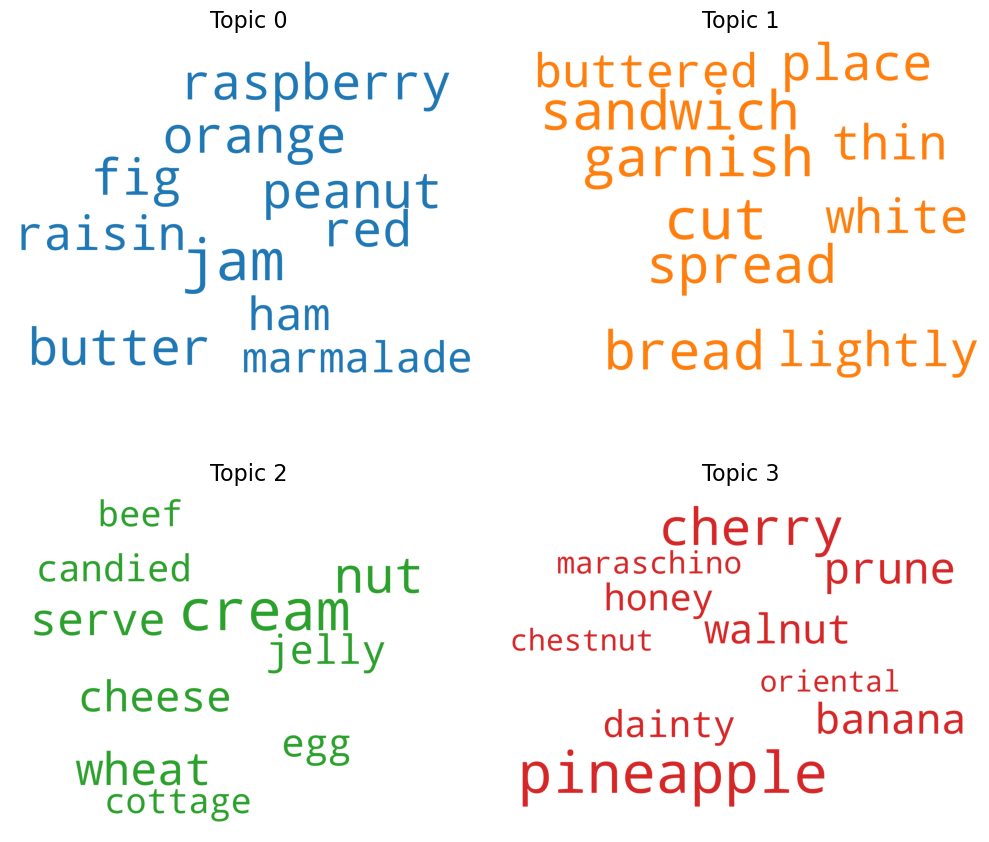

In [18]:
word_clouds_per_topic(lda_model)

In [19]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 233 samples in 0.003s...
[t-SNE] Computed neighbors for 233 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 233 / 233
[t-SNE] Mean sigma: 0.076507
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.425266
[t-SNE] KL divergence after 1000 iterations: 0.215080


In [20]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource
import numpy as np
import matplotlib.colors as mcolors

# Assuming tsne_lda is the resulting matrix from t-SNE with point coordinates
# Assuming topic_num is an array with topic numbers for each point

# Enable Bokeh in the notebook
output_notebook()

# Number of topics
n_topics = 4

# Define colors
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

# Create the figure
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              width=900, height=700)

# Data source
source = ColumnDataSource(data=dict(
    x=tsne_lda[:, 0],
    y=tsne_lda[:, 1],
    colors=mycolors[topic_num]
))

# Add points to the plot
plot.scatter(x='x', y='y', color='colors', source=source)

# Show the plot
show(plot)


Loading BokehJS ...

In [65]:
! pip install pyLDAvis
!pip install --upgrade pandas
!pip install --upgrade numpy
!pip install --upgrade pyLDAvis
!pip install --upgrade gensim
!pip install --upgrade bottleneck



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for bottleneck: filename=Bottleneck-1.3.8-cp311-cp311-macosx_11_0_arm64.whl size=92036 sha256=c27c1a6039ea17b3880ff077c253af00e02b2b8bd13f5b2b2fb241331a2a68c4
  Stored in directory: /Users/eryclisrodrigues/Library/Caches/pip/wheels/32/06/5d/c522b99a4d44c0a76f2359e21ecf39b7349cbb53a56681da76
Successfully built bottleneck
  Attempting uninstall: bottleneck
    Found existing installation: Bottleneck 1.3.5
    Uninstalling Bottleneck-1.3.5:
      Successfully uninstalled Bottleneck-1.3.5


In [21]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()


In [22]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

from gensim import corpora, models
from gensim.models.ldamodel import LdaModel

# Supomos que lda_model, corpus e id2word2 já estão definidos
# lda_model: Seu modelo LDA treinado
# corpus: Seu corpus usado para treinar o modelo LDA
# id2word2: O dicionário usado no modelo LDA

# Evitar problemas de multiprocessing
import multiprocessing
multiprocessing.set_start_method('fork', force=True)

try:
    vis = gensimvis.prepare(lda_model, corpus, id2word2, mds='pcoa', sort_topics=False)
except Exception as e:
    print(f"An error occurred: {e}")

pyLDAvis.display(vis)


